In [4]:
!uv pip install jupyterlab-vim

Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv
Resolved 93 packages in 111ms
Installed 1 package in 14ms
 + jupyterlab-vim==4.1.4


In [1]:
## juperlab is annoying if you dont have the correct working version
!uv pip list | grep jupyterlab

jupyterlab                4.5.0a0
jupyterlab-pygments       0.3.0
jupyterlab-server         2.27.3
jupyterlab-widgets        3.0.15


Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv


In [2]:
!uv pip list | grep fastplotlib

fastplotlib               0.5.0


Using Python 3.11.12 environment at: C:\Users\RBO\repos\masknmf-toolbox\.venv


In [3]:
%matplotlib inline
%load_ext autoreload
   
from pathlib import Path
import fastplotlib as fpl
import os
import sys
import masknmf
import tifffile
import torch
import numpy as np

import matplotlib.pyplot as plt
import time

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

## Load in a raw suite2p binary: `data.bin`

- the ops.npy file contains the keys 'nframes', 'Lx' and 'Ly', used to reshape the data

In [5]:
reg_file = Path(r"D:\demo\suite2p_results\plane1\data.bin")
raw_file = Path(r"D:\demo\suite2p_results\plane1\data_raw.bin")
ops = np.load(Path(r"D:\demo\suite2p_results\plane1\ops.npy"), allow_pickle=True).item()

In [6]:
nt = ops["nframes"]
Lx = ops["Lx"]
Ly = ops["Ly"]

nt, Lx, Ly

(903, 448, 448)

In [9]:
data_raw = np.memmap(raw_file, shape=(nt, Lx, Ly), dtype=np.int16)
data_reg = np.memmap(reg_file, shape=(nt, Lx, Ly), dtype=np.int16)

reg_mean = np.mean(data_reg, axis=0)
mean_sub = data_reg - reg_mean

In [ ]:
iw = fpl.ImageWidget(data=[data_raw, data_reg, mean_sub], names=["Raw", "Registered", "Reg, Mean-Sub"], figure_shape=(1, 3))
iw.show()

In [ ]:
iw.close()

In [11]:
pixel_weighting = torch.from_numpy(np.std(data_reg, axis = 0))

In [12]:
rigid_strategy = masknmf.RigidMotionCorrection(
    max_shifts = [5, 5]
)
pwrigid_strategy = masknmf.PiecewiseRigidMotionCorrection(
    num_blocks = [32, 32], 
    overlaps = [5, 5],
    max_rigid_shifts = [5, 5],
    max_deviation_rigid = [2, 2]
)

pwrigid_strategy = masknmf.motion_correction.compute_template(
    data_reg,
    rigid_strategy,
    num_iterations_piecewise_rigid = 1,
    pwrigid_strategy = pwrigid_strategy,
    device = "cpu", 
    batch_size = 1000
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]


## TODO: Save moco_results so if you need to restart kernel you can reload them

In [14]:
moco_results = masknmf.RegistrationArray(data_reg, pwrigid_strategy, device = "cuda")

In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0


In [ ]:
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [17]:
dense_moco = moco_results[:]
mean_dense = np.mean(dense_moco, axis=0)
mean_sub_dense = dense_moco - mean_dense

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
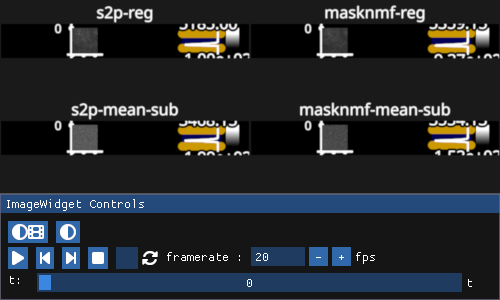

Draw error: Validation Error (3)


In [24]:
iw = fpl.ImageWidget(
    data = [data_reg, dense_moco, mean_sub, mean_sub_dense],
    names = ['s2p-reg', 'masknmf-reg', 's2p-mean-sub', 'masknmf-mean-sub'],
    figure_shape=(2, 2),
    cmap="gray",
)
iw.show()

In [25]:
iw.close()

In [ ]:
np.savez("pmd_reg_subfov.npz", pmd_obj)

In [31]:
pmd_obj_s2p = masknmf.compression.pmd_decomposition(
    data_reg, [32, 32],
    data_reg.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

pmd_obj_nmf = masknmf.compression.pmd_decomposition(
    dense_moco, [32, 32],
    dense_moco.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cpu"
)

[25-05-14 14:02:43]: Starting compression
[25-05-14 14:02:43]: sampled from the following regions: [0]
[25-05-14 14:02:43]: We are initializing on a total of 903 frames
[25-05-14 14:02:44]: Approximating full FOV basis terms
[25-05-14 14:02:44]: Loading data to estimate complete spatial basis
[25-05-14 14:02:44]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 191.93it/s]

[25-05-14 14:02:45]: Running Blockwise Decompositions


[25-05-14 14:02:48]: Constructed U matrix. Rank of U is 2101
[25-05-14 14:02:48]: PMD Objected constructed
[25-05-14 14:02:48]: Starting compression
[25-05-14 14:02:48]: sampled from the following regions: [0]
[25-05-14 14:02:48]: We are initializing on a total of 903 frames
[25-05-14 14:02:49]: Approximating full FOV basis terms
[25-05-14 14:02:49]: Loading data to estimate complete spatial basis
[25-05-14 14:02:49]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 200.07it/s]

[25-05-14 14:02:50]: Running Blockwise Decompositions


[25-05-14 14:02:53]: Constructed U matrix. Rank of U is 2179
[25-05-14 14:02:53]: PMD Objected constructed


RFBOutputContext()

C:\Users\RBO\repos\masknmf-toolbox\.venv\Lib\site-packages\fastplotlib\graphics\_features\_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
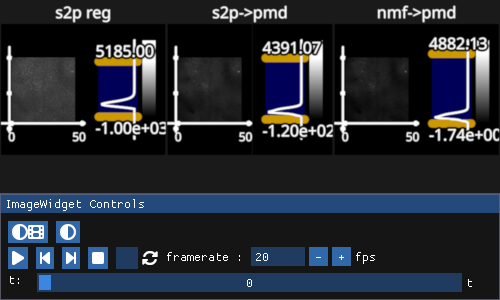

Draw error: Validation Error (6)


In [33]:
iw = fpl.ImageWidget(
    data = [data_reg, pmd_obj_s2p, pmd_obj_nmf],
    names = ['s2p reg', 's2p->pmd', 'nmf->pmd'],
    figure_shape=(1,3),
    cmap="gray",
)
iw.show()

In [34]:
iw.close()

In [35]:
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_obj_nmf,
    device=device,
    frame_batch_size=100
)

Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


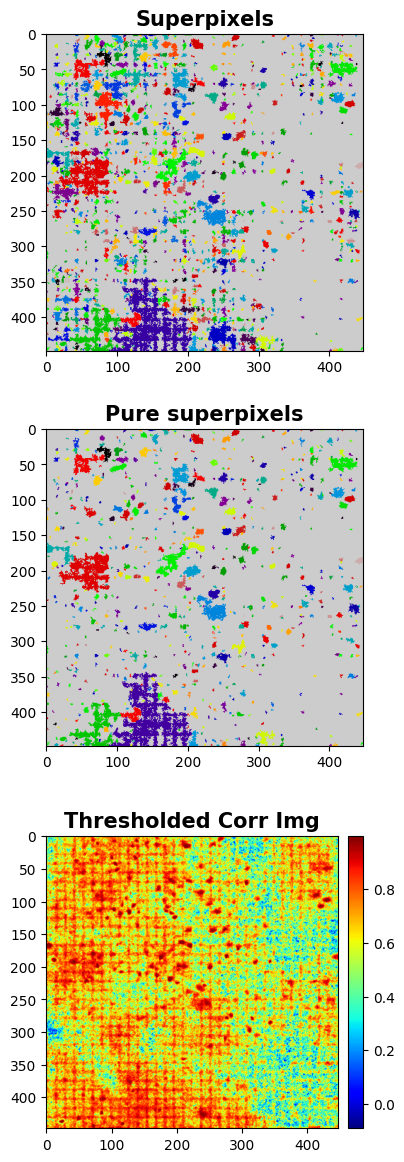

Identified 711 neurons here


In [36]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

## Increasing pmd block size 32x32 -> 64x64

[25-05-14 14:42:04]: Starting compression
[25-05-14 14:42:04]: sampled from the following regions: [0]
[25-05-14 14:42:04]: We are initializing on a total of 903 frames
[25-05-14 14:42:04]: Approximating full FOV basis terms
[25-05-14 14:42:04]: Loading data to estimate complete spatial basis
[25-05-14 14:42:05]: Finding spatiotemporal roughness thresholds


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 344.59it/s]

[25-05-14 14:42:05]: Running Blockwise Decompositions


[25-05-14 14:42:09]: Constructed U matrix. Rank of U is 2213
[25-05-14 14:42:09]: PMD Objected constructed
Computing correlation data structure with MAD threshold  1and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


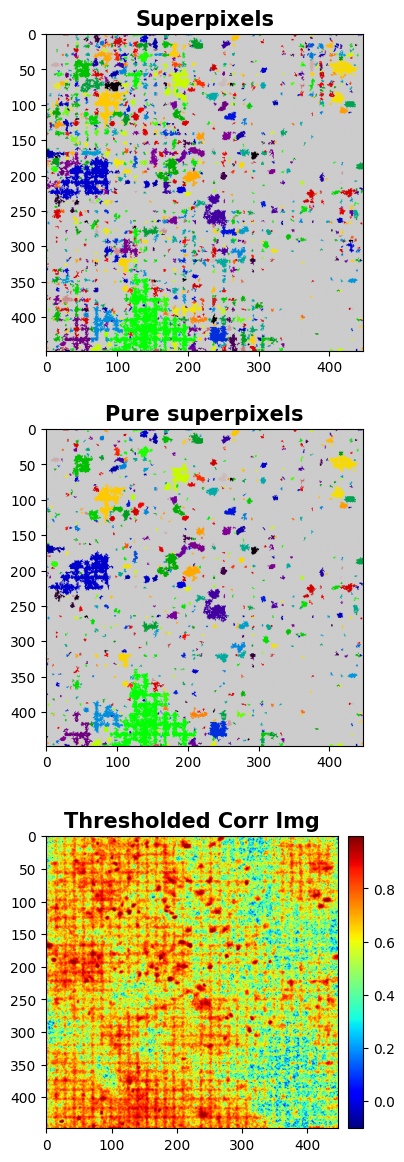

Identified 722 neurons here


In [49]:
pmd_obj_nmf = masknmf.compression.pmd_decomposition(
    dense_moco, [32, 32],
    dense_moco.shape[0],
    max_components = 10,
    background_rank = 10,
    device = "cuda"
)

num_frames, fov_dim1, fov_dim2 = pmd_obj_nmf.shape
device = 'cuda'
pmd_demixer = masknmf.demixing.signal_demixer.SignalDemixer(
    pmd_obj_nmf,
    device=device,
    frame_batch_size=100
)

init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.85,

    #Mostly stable
    'min_superpixel_size':5,
    'robust_corr_term':1,
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")


In [50]:
print(pmd_demixer.state.state_description)

Initialization state: identify initial estimates of the signals present in the data


In [51]:
pmd_demixer.lock_results_and_continue()

Now in demixing state


In [52]:
## Demixing State

num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [30:02<00:00, 72.09s/it]


that took 1804.2344808578491
after this step 722 signals identified


RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
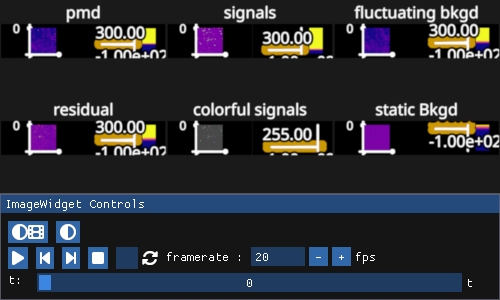

Draw error: Validation Error (7)


In [53]:
# If desired, you can view the demixing results at this stage
iw = masknmf.visualization.make_demixing_video(
    pmd_demixer.results,
    device,
    show_histogram = True,
    v_range = [-100, 300],
)

iw.show()

In [54]:
iw.close()

In [55]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in the initialization state


In [56]:
print(pmd_demixer.state.state_description)

Initialization state: identify initial estimates of the signals present in the data


Computing correlation data structure with MAD threshold  0and the robust corr term is 1
find superpixels!
find pure superpixels!
prepare iteration!


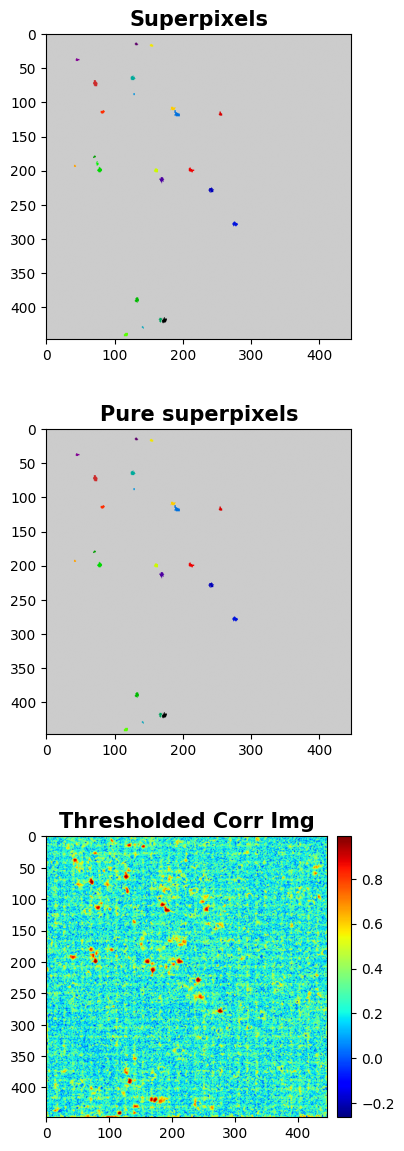

Identified 745 neurons here


In [57]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.9,
    'min_superpixel_size':5,
    'robust_corr_term':1,

    #Mostly stable
    'mad_threshold':0,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'plot_en':True,
    'text':False,
}

pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {pmd_demixer.results[0].shape[1]} neurons here")

In [58]:
# Move to next stage demixing
pmd_demixer.lock_results_and_continue(carry_background=True)

Now in demixing state


In [59]:
## Demixing State
num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.95, 0.8, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt': 4,
    'ring_radius':10,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4,
    'c_nonneg':True,
    'denoise':False,
    'plot_en': True
}

start_time = time.time()
with torch.no_grad():
    pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {pmd_demixer.results.a.shape[1]} signals identified")



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [30:09<00:00, 72.40s/it]


that took 1811.8009195327759
after this step 745 signals identified


In [60]:
a = pmd_demixer.results.ac_array.export_a()
c = pmd_demixer.results.ac_array.export_c()

#"a" is a fov dim1 x fov dim2 x number of neurons numpy.ndarray
#"c" is a num_frames x num_neurons np.ndarray

In [61]:
np.savez("./pmd_obj_plane1_fullFOV.npz", pmd_obj_nmf)

In [63]:
a.shape, c.shape

((448, 448, 745), (903, 745))

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt

import numpy as np
from matplotlib.patches import Rectangle
from skimage.measure import find_contours
from matplotlib import cm

def plot_pmd_projection(proj=None, a=None, savepath=None, fig_label=None, vmin=None, vmax=None, add_scalebar=False, dx=2.0, title=None):
    shape = a.shape
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')

    if proj is not None:
        if vmin is None:
            vmin = np.nanpercentile(proj, 2)
        if vmax is None:
            vmax = np.nanpercentile(proj, 98)
        if vmax - vmin < 1e-6:
            vmax = vmin + 1e-6
        ax.imshow(proj, cmap='gray', vmin=vmin, vmax=vmax)

    n_rois = a.shape[-1]
    colors = cm.get_cmap("nipy_spectral", n_rois)

    for i in range(n_rois):
        mask = a[..., i]
        contours = find_contours(mask, level=0.1)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], color=colors(i), linewidth=0.8)

    ax.set_xticks([])
    ax.set_yticks([])

    if fig_label:
        fig_label = fig_label.replace("_", " ").replace("-", " ").replace(".", " ")
        ax.set_ylabel(fig_label, color='white', fontweight='bold', fontsize=12)

    if fig_label:
        fig_label = fig_label.replace("_", " ").replace("-", " ").replace(".", " ")
        ax.set_ylabel(fig_label, color='white', fontweight='bold', fontsize=12)

    if title:
        ax.set_title(title, fontsize=20, color='white', fontweight='bold', fontname='Arial')

    if add_scalebar:
        scale_bar_length = 100 / dx
        scalebar_x = shape[1] * 0.05
        scalebar_y = shape[0] * 0.90
        ax.add_patch(Rectangle((scalebar_x, scalebar_y), scale_bar_length, 5,
                               edgecolor='white', facecolor='white'))
        ax.text(scalebar_x + scale_bar_length / 2, scalebar_y - 10,
                "100 μm", color='white', fontsize=10, ha='center', fontweight='bold')

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    if savepath:
        savepath.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=300, facecolor='black')
        plt.close(fig)
    else:
        plt.show()

In [51]:
def get_mean(file):
    return np.mean(tifffile.memmap(file), axis=0)

In [54]:
means = []
for i, file in enumerate(assembled_files):
    mean = get_mean(assembled_files[i])
    means.append(mean)

C:\Users\RBO\AppData\Local\Temp\ipykernel_21896\1383611016.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("nipy_spectral", n_rois)


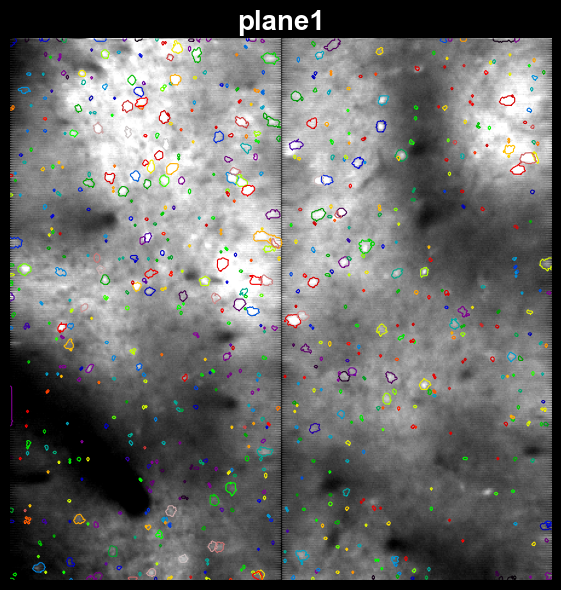

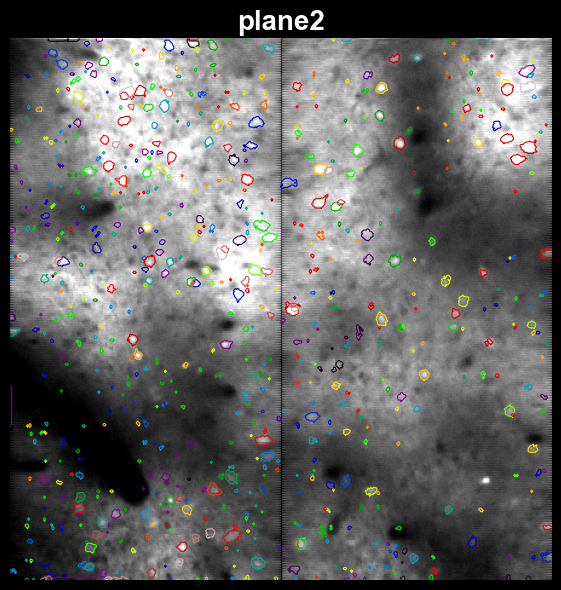

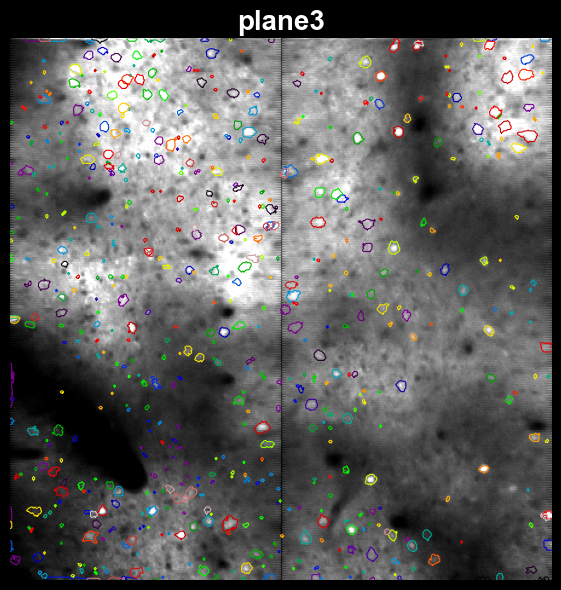

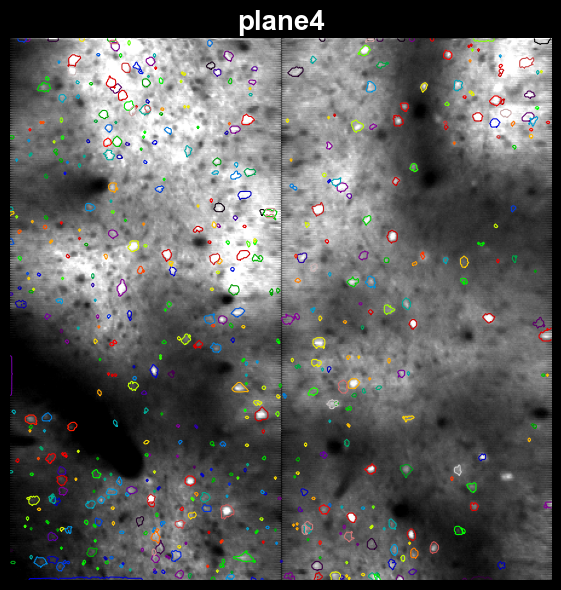

In [55]:
dpath = Path(r"C:\Users\RBO\.masknmf")

planes = [x for x in dpath.iterdir()]

for i, filepath in enumerate(planes):
    title = filepath.stem
    ops = np.load(filepath.joinpath("ops.npy"), allow_pickle=True).item()
    with np.load(filepath.joinpath("pmd_final_a.npz")) as data:
       a = np.load(filepath.joinpath("pmd_final_a.npz"))
       plot_pmd_projection(means[i], a['arr_0'], dx=2.0, title=title)

In [72]:
mean_img = np.mean(data_reg, axis=0)  # or use a registered mean if available
mean_img.shape, a.shape

((448, 448), (448, 448, 745))

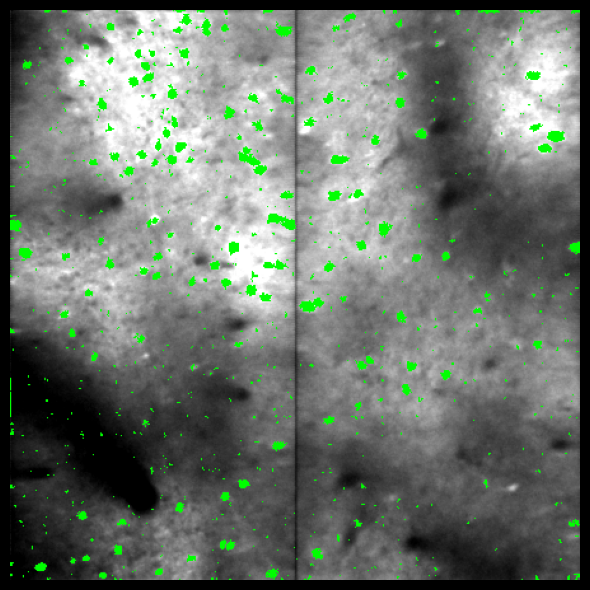

In [73]:
plot_pmd_projection(mean_img, a, dx=2.0)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
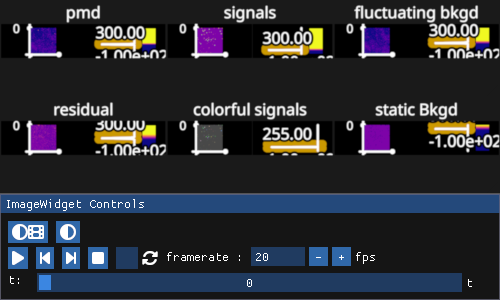

In [74]:
iw = masknmf.visualization.make_demixing_video(
    pmd_demixer.results,
    device,
    show_histogram = True,
    v_range = [-100, 300],
)
iw.show()